<a href="https://colab.research.google.com/github/Abhishekdileep/DIAT_repo/blob/main/Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.4.1
!pip install matplotlib
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.3 MB 10 kB/s 
     |████████████████████████████████| 462 kB 55.4 MB/s 
     |████████████████████████████████| 2.9 MB 40.1 MB/s 
     |████████████████████████████████| 14.8 MB 36.0 MB/s 
     |████████████████████████████████| 3.8 MB 43.6 MB/s 
     |████████████████████████████████| 132 kB 68.3 MB/s 
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4848 sha256=1fd3909292bd695d9002482e089b6ba51bf435802d5bc7852f9a884899d799f5
  Stored in directory: /root/.cache/pip/wheels/3f/e3/ec/8a8336ff196023622fbcb36de0c5a5c218cbb24111d1d4c7f2
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68719 sha256=2256b521508707ce43d6a222d78dc66cb6b6c150d10aedc9f82bac09484a6d57
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built term

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 4.2 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 84 kB 1.7 MB/s 
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 2.3 MB 45.0 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 272 kB 62.5 MB/s 
     |████████████████████████████████| 106 kB 51.4 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 213 kB 65.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 68 kB 6.2 MB/s 
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |██

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
import gradio as gr

In [ ]:

# model_name = "movenet_lig
# !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

In [ ]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 4, (0,255,0), -1)

In [ ]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [ ]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]

        if (c1 > confidence_threshold) & (c2 > confidence_threshold):
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 2)

##Video Inference Code , Need to recreate GUI for the same


In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read() #how to input display

    # Reshape image
    img = frame.copy()
    img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
    input_image = tf.cast(img, dtype=tf.float32)

    # Setup input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Make predictions
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

    # Rendering
    draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
    draw_keypoints(frame, keypoints_with_scores, 0.4)

    cv2.imshow('MoveNet Lightning', frame) #how to show display

    if cv2.waitKey(10) & 0xFF==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 332, 'shape': array([ 1,  1, 17,  3], dtype=int32), 'shape_signature': array([ 1,  1, 17,  3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


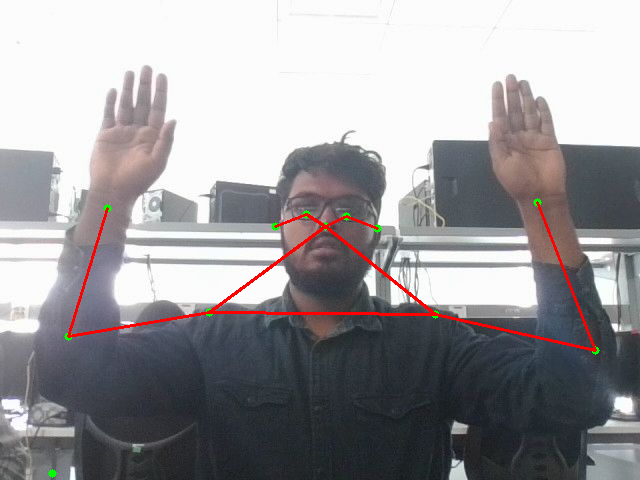

In [ ]:
from google.colab.patches import cv2_imshow
frame = cv2.imread('photo.jpg' )
img = frame.copy()
img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
input_image = tf.cast(img, dtype=tf.float32)

# Setup input and output
input_details = interpreter.get_input_details()
print(input_details)
output_details = interpreter.get_output_details()
print(output_details)

# Make predictions
interpreter.set_tensor(input_details[0]['index'], np.array(input_image).astype(np.uint8))
interpreter.invoke()
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

# Rendering
draw_keypoints(frame, keypoints_with_scores, 0.4)
draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
cv2_imshow( frame)



# Old Code , Don't Run if not needed

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


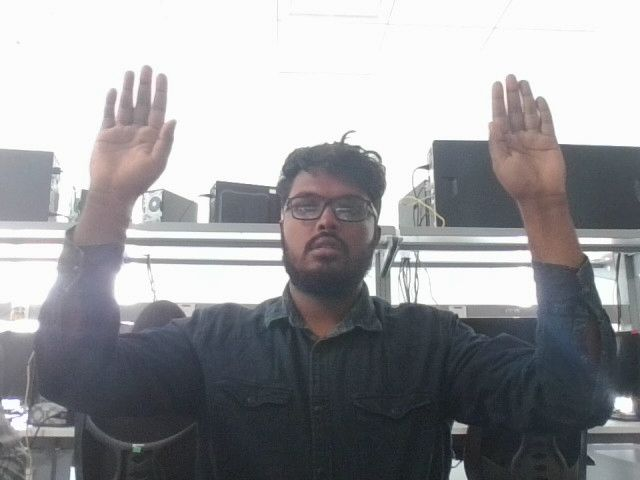

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
def test_func(file):
    cap = cv2.VideoCapture(file)
    frame_width = 100
    frame_height = 100

    size = (frame_width, frame_height)

    # Below VideoWriter object will create
    # a frame of above defined The output
    # is stored in 'filename.avi' file.
    result = cv2.VideoWriter('filename.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)
    while cap.isOpened():
      # ret, frame = cv2.imread(file) #how to input display
      # img = frame.copy()
      # img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 192,192)
      # input_image = tf.cast(img, dtype=tf.float32)

      # # Setup input and output
      # input_details = interpreter.get_input_details()
      # output_details = interpreter.get_output_details()

      # # Make predictions
      # interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
      # interpreter.invoke()
      # keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

      # # Rendering
      # draw_connections(frame, keypoints_with_scores, EDGES, 0.4)
      # draw_keypoints(frame, keypoints_with_scores, 0.4)

      #Writing the video with videowriter

      # print(frame )
      cv2_imshow(frame)
      result.write(frame)
    cap.release()
    result.release()
    print("relased")

In [ ]:
# with gr.Blocks() as demo:
#   iideo = gr.Video(test_func,  source='webcam' , format='mp4' )
#   iideo.change( test_func, inputs=iideo, outputs=iideo ,   queue=True , every=0.1 )

# demo.launch(debug=True)
# gr.Interface(test_func , inputs = gr.Video( source = 'webcam' , format='mp4' ) , outputs=gr.Video() , live=True).launch(debug=True)

# with gr.Blocks() as demo:
#   image  = gr.Image(source='webcam', streaming=True , type='numpy')

gr.Interface(test_func , inputs =  gr.Video( source = 'webcam' , format='mp4' ) , outputs=None, live=True).queue().launch(debug=True)

# demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://29c8c0895430733b.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


#Code for porting the video to save file

In [ ]:

# Create an object to read
# from camera
video = cv2.VideoCapture(0)

# We need to check if camera
# is opened previously or not
if (video.isOpened() == False):
    print("Error reading video file")

# We need to set resolutions.
# so, convert them from float to integer.
frame_width = int(video.get(3))
frame_height = int(video.get(4))

size = (frame_width, frame_height)

# Below VideoWriter object will create
# a frame of above defined The output
# is stored in 'filename.avi' file.
result = cv2.VideoWriter('filename.avi',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

while(True):
    ret, frame = video.read()

    if ret == True:

        # Write the frame into the
        # file 'filename.avi'
        result.write(frame)

        # Display the frame
        # saved in the file
        cv2.imshow('Frame', frame)

        # Press S on keyboard
        # to stop the process
        if cv2.waitKey(1) & 0xFF == ord('s'):
            break

    # Break the loop
    else:
        break

# When everything done, release
# the video capture and video
# write objects
video.release()
result.release()

# Closes all the frames
cv2.destroyAllWindows()

print("The video was successfully saved")